In [1]:
#import tool
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import ImageColor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
path = 'dataset_ECT.xlsx'

In [2]:
#read sheet
result_constituencies_PartyList = pd.read_excel(path, sheet_name="result_constituencies_PartyList")
info_party_overview = pd.read_excel(path, sheet_name="info_party_overview")
result_constituencies_status = pd.read_excel(path, sheet_name="result_constituencies_status")
info_party_overview = pd.read_excel(path, sheet_name="info_party_overview")
info_constituency = pd.read_excel(path, sheet_name="info_constituency")
result_constituencies_Candidate = pd.read_excel(path, sheet_name="result_constituencies_Candidate")
Candidate_Constituency = pd.read_excel(path, sheet_name="Candidate_Constituency")

In [3]:
def PlotCatStackBar(n1,n2,df):
  # สร้าง stack barplot
  cross_tab = pd.crosstab(df[n1], df[n2])
  ax = cross_tab.plot(kind='bar', stacked=True, figsize=(30, 8))
  Percent = cross_tab.div(cross_tab.sum(axis=1), axis=0).values.T.flatten()

  # กำหนดชื่อแกน x และ y
  plt.xlabel(n1)
  plt.ylabel('Count')

  # กำหนดชื่อสำหรับแต่ละส่วนของ stack barplot
  ax.legend(title=n2)


def PlotBarCharts(inpData, colsToPlot):
    %matplotlib inline

    import matplotlib.pyplot as plt

    # Generating multiple subplots
    fig, subPlot=plt.subplots(nrows=1, ncols=len(colsToPlot), figsize=(40,6))
    fig.suptitle('Bar charts of: '+ str(colsToPlot))

    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        inpData.groupby(colName).size().plot(kind='bar',ax=subPlot[plotNumber])

# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)

        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])

    return(SelectedPredictors)


# Data Gathering
our assumption is to predict that is a constituencies will have a people come to registed vote more than 71 % so in ECT dataset we gonna find attribute that represent at numberical and not invole the result of election here is the attribute that we get from ECT dataset :

    - count vote station (counted_vote_stations)
    - total of people who can registed to vote at each constituencies (registred_vote)
    - zone count of each constituencies (zone_count)
    - ms,mr and other count of each constituencies (ms_count , mr_count, other_count)


In [4]:
#here is the code where we gather data form ECT dataset
# calculate new percent vote by summing information in each Party
cons_id = result_constituencies_PartyList['cons_id']
party_id = result_constituencies_PartyList['party_id']
party_list_vote = result_constituencies_PartyList['party_list_vote']
party_list_vote_percent = result_constituencies_PartyList['party_list_vote_percent']

#get total vote dict
registered_vote = {}
total_count = {}
all_cons_id = info_constituency['cons_id']
all_regis_vote = info_constituency['registered_vote']
total_count_station = info_constituency['total_vote_stations']

for i in range(len(all_cons_id)): 
    if all_cons_id[i] not in registered_vote.keys() :       
        registered_vote[all_cons_id[i]] = all_regis_vote[i]
        total_count[all_cons_id[i]] = total_count_station[i]

# get sum information of each constituencies
cons_info = {}
for i in range(len(cons_id)):
    if cons_id[i] not in cons_info.keys():
        cons_info[cons_id[i]] = [party_list_vote[i],party_list_vote_percent[i]]
    else : 
        cons_info[cons_id[i]][0]+=party_list_vote[i]
        cons_info[cons_id[i]][1]+=party_list_vote_percent[i]

# calculate new percent for each constituencies
percent_vote_in_con = {}
for i in cons_info.keys():
    percent_vote_in_con[i] = cons_info[i][0] / registered_vote[i]

# get information about counted vote stations
counted_vote_stations_dict = {}
counted_vote_stations = list(result_constituencies_status['counted_vote_stations'])
cons_id_result_constituencies_status = list(result_constituencies_status['cons_id'])
for i in range(len(cons_id_result_constituencies_status)) :
    counted_vote_stations_dict[cons_id_result_constituencies_status[i]] = counted_vote_stations[i]

# get win party information for each constituencies
win_cons_id_to_party_id = {}
cons_id_result_con_candidate = result_constituencies_Candidate['cons_id']
mp_app_rank_result_con_candidate = result_constituencies_Candidate['mp_app_rank']
party_id_result_con_candidate = result_constituencies_Candidate['party_id']
for i in range(len(cons_id_result_con_candidate)):
    if mp_app_rank_result_con_candidate[i] == 1 :
        win_cons_id_to_party_id[cons_id_result_con_candidate[i]] = party_id_result_con_candidate[i]

# # get 
# party_no = info_party_overview ['id']
# color = info_party_overview ['color']
# party_no_to_color_rgb = {}
# for i in range(len(party_no)):
#     party_no_to_color_rgb[party_no[i]] = ImageColor.getcolor(str(color[i]), "RGB")

#gather information into one dataframe
df_con = []
for i in cons_info.keys() :
    # df_con.append([i,percent_vote_in_con[i],registered_vote[i],counted_vote_stations_dict[i],party_no_to_color_rgb[win_cons_id_to_party_id[i]]])
    df_con.append([i,percent_vote_in_con[i],registered_vote[i],total_count[i]])
df_con = pd.DataFrame(df_con)
df_con.columns = ['cons_id','percent_vote_in_con', 'registered_vote', 'counted_vote_stations']

In [5]:
# prepare data for gender count in each contituencies
cons_id = list(df_con['cons_id'])
mp_app_id = list(Candidate_Constituency['mp_app_id'])
mp_app_name = list(Candidate_Constituency['mp_app_name'])

dict_constituency_mp = {}
for i in range(len(mp_app_id)):
    # print(mp_app_id[i][:5])
    idx = mp_app_id[i].find('_',4)
    name = mp_app_id[i][:idx]
    # print(name ,idx,mp_app_name[i])
    if name in dict_constituency_mp.keys() :
        list_name =  dict_constituency_mp[name]
        list_name.append(mp_app_name[i])
        dict_constituency_mp[name] = list_name
    else : dict_constituency_mp[name] = [mp_app_name[i]]

# dict_constituency_mp['BKK_10']
# get profix name
dict_count_prefix_ms = {} #นางสาว
dict_count_prefix_mr = {} # นาย
dict_count_prefix_other = {} # อื่นๆ
for i in cons_id :
    ms,mr,other = 0,0,0
    for j in dict_constituency_mp[i] :
        if 'นายดาบตำรวจ' in j :other+=1
        elif j.split("นาย")[0]==''  :mr+=1
        elif j.split('นางสาว')[0]=='' :ms+=1
        else :other+=1
    dict_count_prefix_ms[i] = ms
    dict_count_prefix_mr[i] = mr
    dict_count_prefix_other[i] = other
# dict_count_prefix_other
mr_count = []
ms_count = []
other_count = []
for i in cons_id:
    max = dict_count_prefix_mr[i] + dict_count_prefix_ms[i] + dict_count_prefix_other[i]
    mr_count.append(dict_count_prefix_mr[i])
    ms_count.append(dict_count_prefix_ms[i])
    other_count.append(dict_count_prefix_other[i])
    
df_con['mr_count'] = mr_count
df_con['ms_count'] = ms_count
df_con['other_count'] = other_count

In [6]:
# get zone count
zone_count = {}
all_cons_id = list(info_constituency['cons_id'])
all_regis_vote = list(info_constituency['registered_vote'])
for i in all_cons_id :
    if i in zone_count.keys():
        zone_count[i]+=1
    else :zone_count[i] = 1
zone_count_list = []
for i in list(df_con['cons_id']):
    zone_count_list.append(zone_count[i])
df_con['zone_count'] = zone_count_list
df_con.head()

label = df_con['percent_vote_in_con']
label = label>0.71
label = list(label.astype(int))
df_con['label'] = label


In [7]:
df_con.head()

,cons_id,percent_vote_in_con,registered_vote,counted_vote_stations,mr_count,ms_count,other_count,zone_count,label
0,ACR_1,0.696987,145416,310,9,2,2,2,0
1,ACR_2,0.685888,155938,331,8,1,3,5,0
2,ATG_1,0.758768,111917,239,6,0,2,3,1
3,ATG_2,0.740755,112739,253,6,3,0,5,1
4,AYA_1,0.752629,138666,226,8,1,1,2,1


# Data exploration
label 0 คือ เขตที่มีผู้มาใช้สิทธิ์เลือกตั้งน้อยกว่า 71%
label 1 คือ เขตที่มีผู้มาใช้สิทธิ์เลือกตั้งมากกว่า 71%

<AxesSubplot: xlabel='label'>

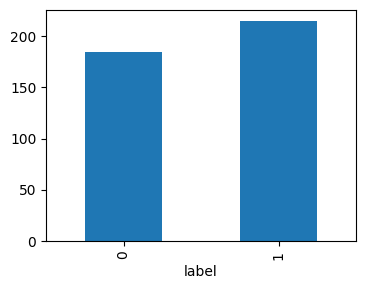

In [8]:
#consider label distribution by bar chart
target=df_con.groupby('label').size()
target.plot(kind='bar', figsize=(4,3))

In [9]:
df_con.head()

,cons_id,percent_vote_in_con,registered_vote,counted_vote_stations,mr_count,ms_count,other_count,zone_count,label
0,ACR_1,0.696987,145416,310,9,2,2,2,0
1,ACR_2,0.685888,155938,331,8,1,3,5,0
2,ATG_1,0.758768,111917,239,6,0,2,3,1
3,ATG_2,0.740755,112739,253,6,3,0,5,1
4,AYA_1,0.752629,138666,226,8,1,1,2,1


In [10]:
df_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cons_id                400 non-null    object 
 1   percent_vote_in_con    400 non-null    float64
 2   registered_vote        400 non-null    int64  
 3   counted_vote_stations  400 non-null    int64  
 4   mr_count               400 non-null    int64  
 5   ms_count               400 non-null    int64  
 6   other_count            400 non-null    int64  
 7   zone_count             400 non-null    int64  
 8   label                  400 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 28.2+ KB


# visualization

## Visualize all attributes 
we visualize 6 attributes which are registered_vote,counted_vote_stations,mr_count, ms_count,other_count and  zone_count. All of the attribute are numurical data so we consider outlier by boxplot and distribution by histogram.

<Figure size 640x480 with 0 Axes>

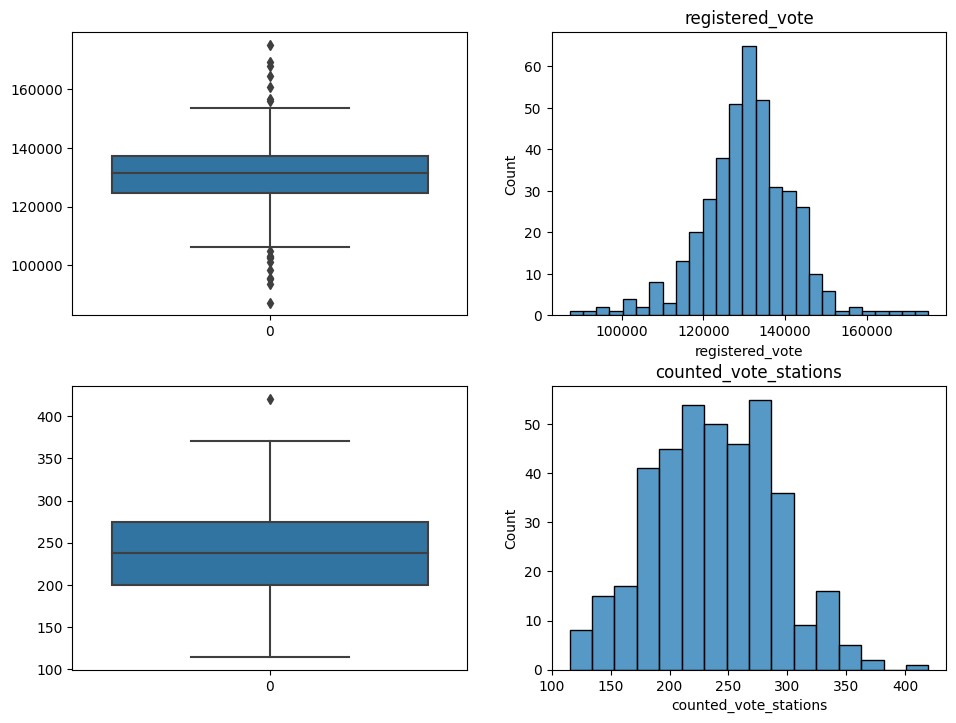

<Figure size 640x480 with 0 Axes>

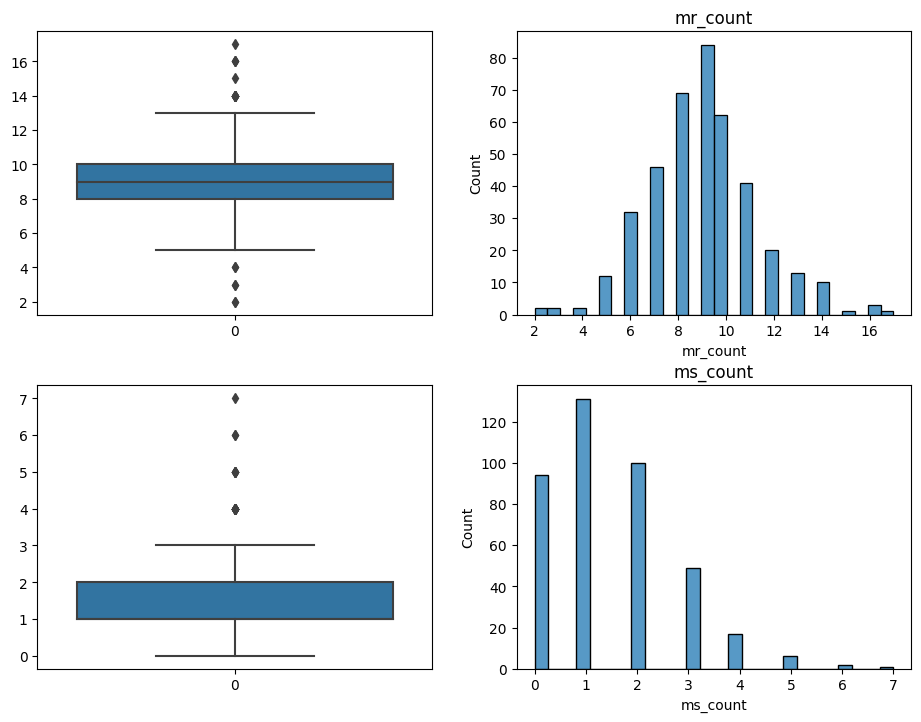

<Figure size 640x480 with 0 Axes>

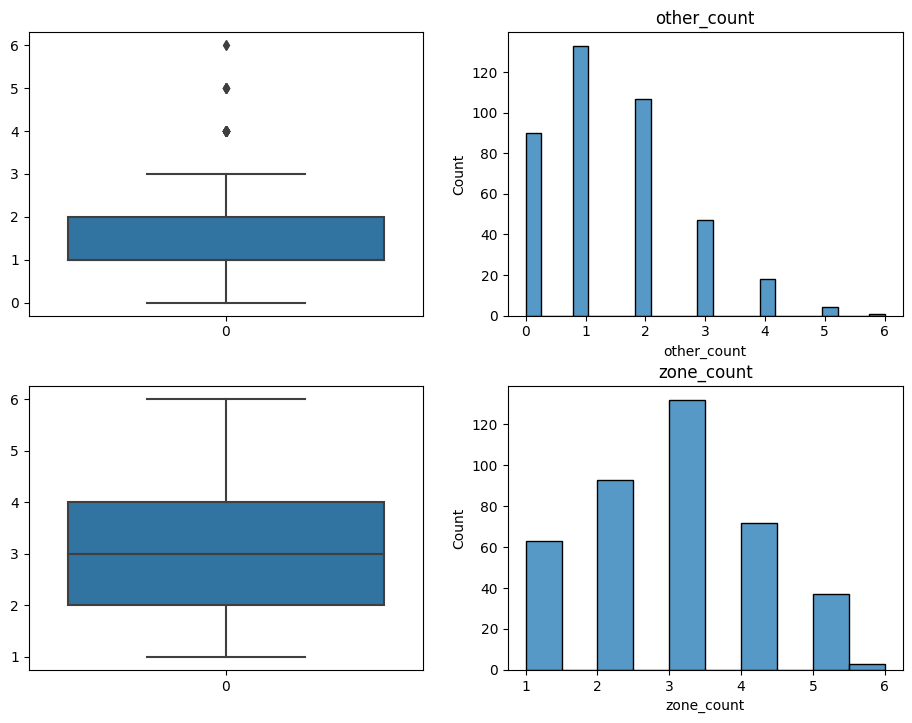

In [11]:
# visualize continue data
plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(10, 7.5))
fig.tight_layout(pad=3.0)
sb.boxplot(df_con['registered_vote'],ax=axes[0,0])
sb.histplot(df_con['registered_vote'],ax=axes[0,1])
axes[0,1].set_title('registered_vote')

sb.boxplot(df_con['counted_vote_stations'],ax=axes[1,0])
sb.histplot(df_con['counted_vote_stations'],ax=axes[1,1])
axes[1,1].set_title('counted_vote_stations')
plt.show()

plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(10, 7.5))
fig.tight_layout(pad=3.0)
sb.boxplot(df_con['mr_count'],ax=axes[0,0])
sb.histplot(df_con['mr_count'],ax=axes[0,1])
axes[0,1].set_title('mr_count')

sb.boxplot(df_con['ms_count'],ax=axes[1,0])
sb.histplot(df_con['ms_count'],ax=axes[1,1])
axes[1,1].set_title('ms_count')
plt.show()

plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(10, 7.5))
fig.tight_layout(pad=3.0)
sb.boxplot(df_con['other_count'],ax=axes[0,0])
sb.histplot(df_con['other_count'],ax=axes[0,1])
axes[0,1].set_title('other_count')

sb.boxplot(df_con['zone_count'],ax=axes[1,0])
sb.histplot(df_con['zone_count'],ax=axes[1,1])
axes[1,1].set_title('zone_count')
plt.show()




In [12]:
# We have 4 attributes that have normal distribution which are registered_vote,counted_vote_stations,mr_count and zone_count so we use anova to find p-value between attributes and label.
ContinuousVariables=["registered_vote",	"counted_vote_stations"	,"mr_count","zone_count"]
FunctionAnova(inpData=df_con, TargetVariable='label', ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

registered_vote is NOT correlated with label | P-Value: 0.8122782652788285
counted_vote_stations is correlated with label | P-Value: 9.868939318336976e-13
mr_count is NOT correlated with label | P-Value: 0.17197917645523694
zone_count is correlated with label | P-Value: 4.5180254689079205e-06


['counted_vote_stations', 'zone_count']

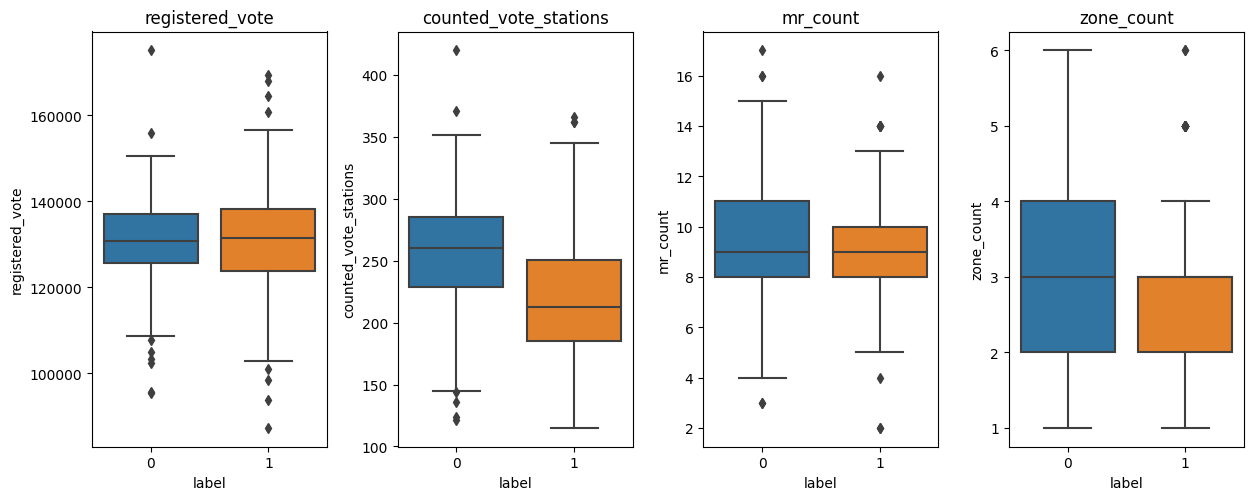

median of zone_count in each label
label
0    3.0
1    3.0
Name: zone_count, dtype: float64


In [13]:
# considering clustering propability by box plot
fig, axes = plt.subplots(1, 4, figsize=(12.5, 5))
fig.tight_layout(pad=2.0)
sb.boxplot(x='label',y='registered_vote',data=df_con,ax=axes[0])
axes[0].set_title('registered_vote')
sb.boxplot(x='label',y='counted_vote_stations',data=df_con,ax=axes[1])
axes[1].set_title('counted_vote_stations')
sb.boxplot(x='label',y='mr_count',data=df_con,ax=axes[2])
axes[2].set_title('mr_count')
sb.boxplot(x='label',y='zone_count',data=df_con,ax=axes[3])
axes[3].set_title('zone_count')
plt.show()

# zone_count median cosideration
print('median of zone_count in each label')
print(df_con.groupby('label')['zone_count'].median())



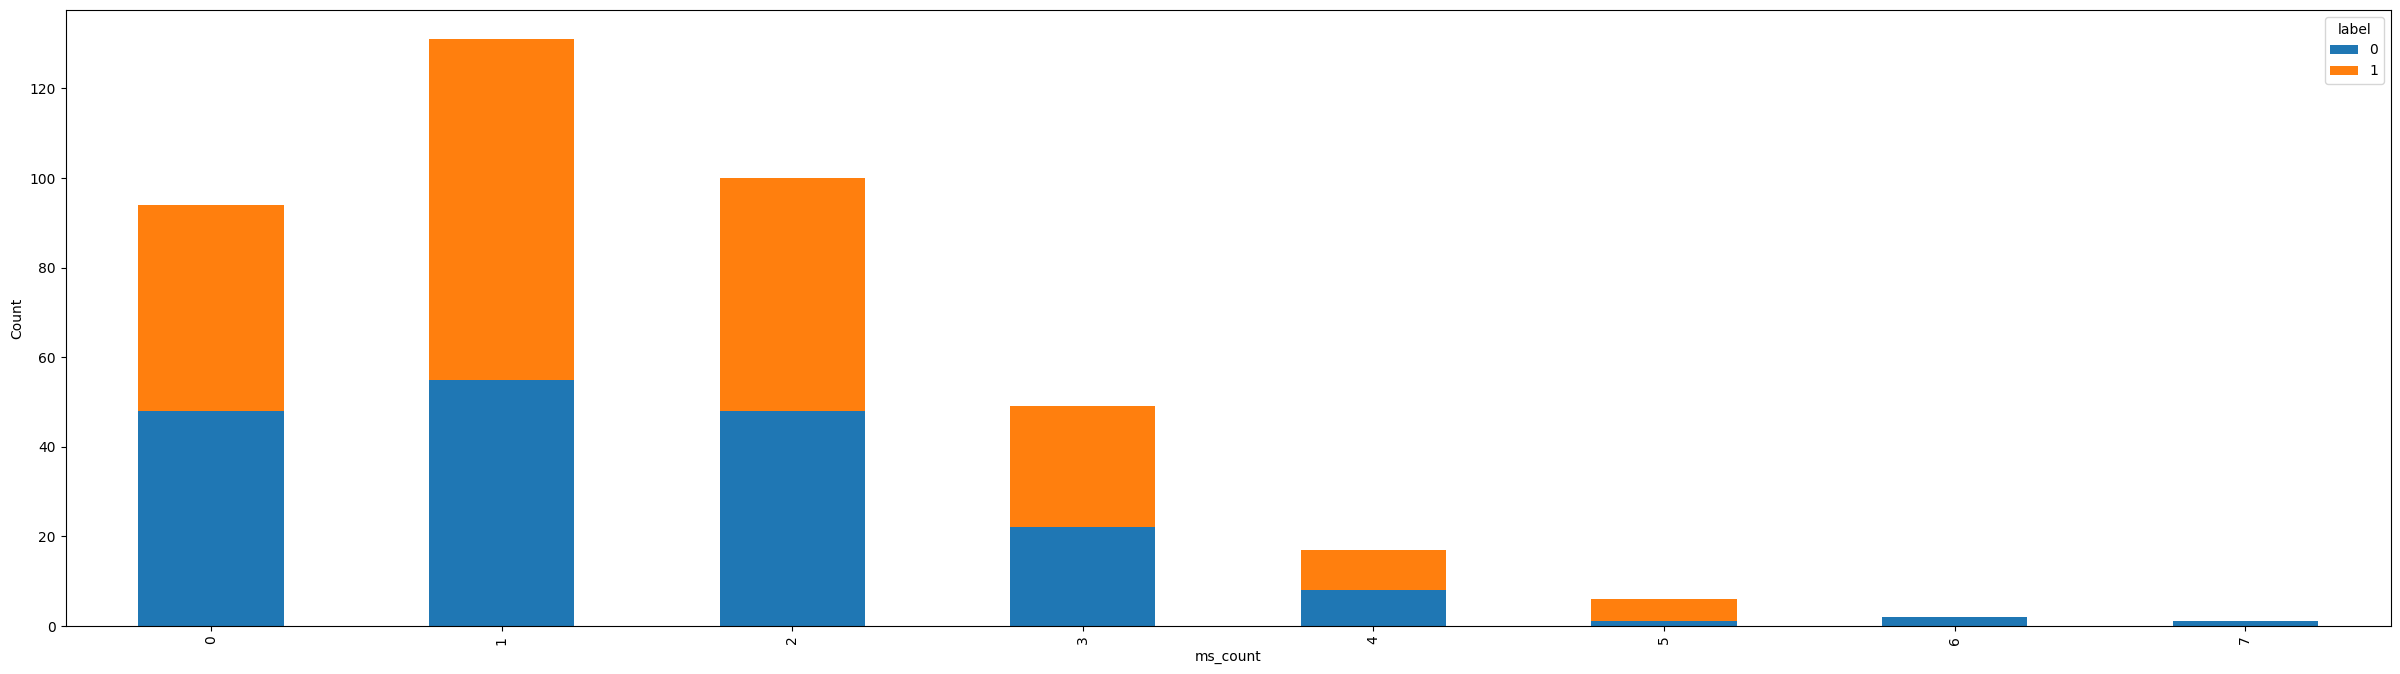

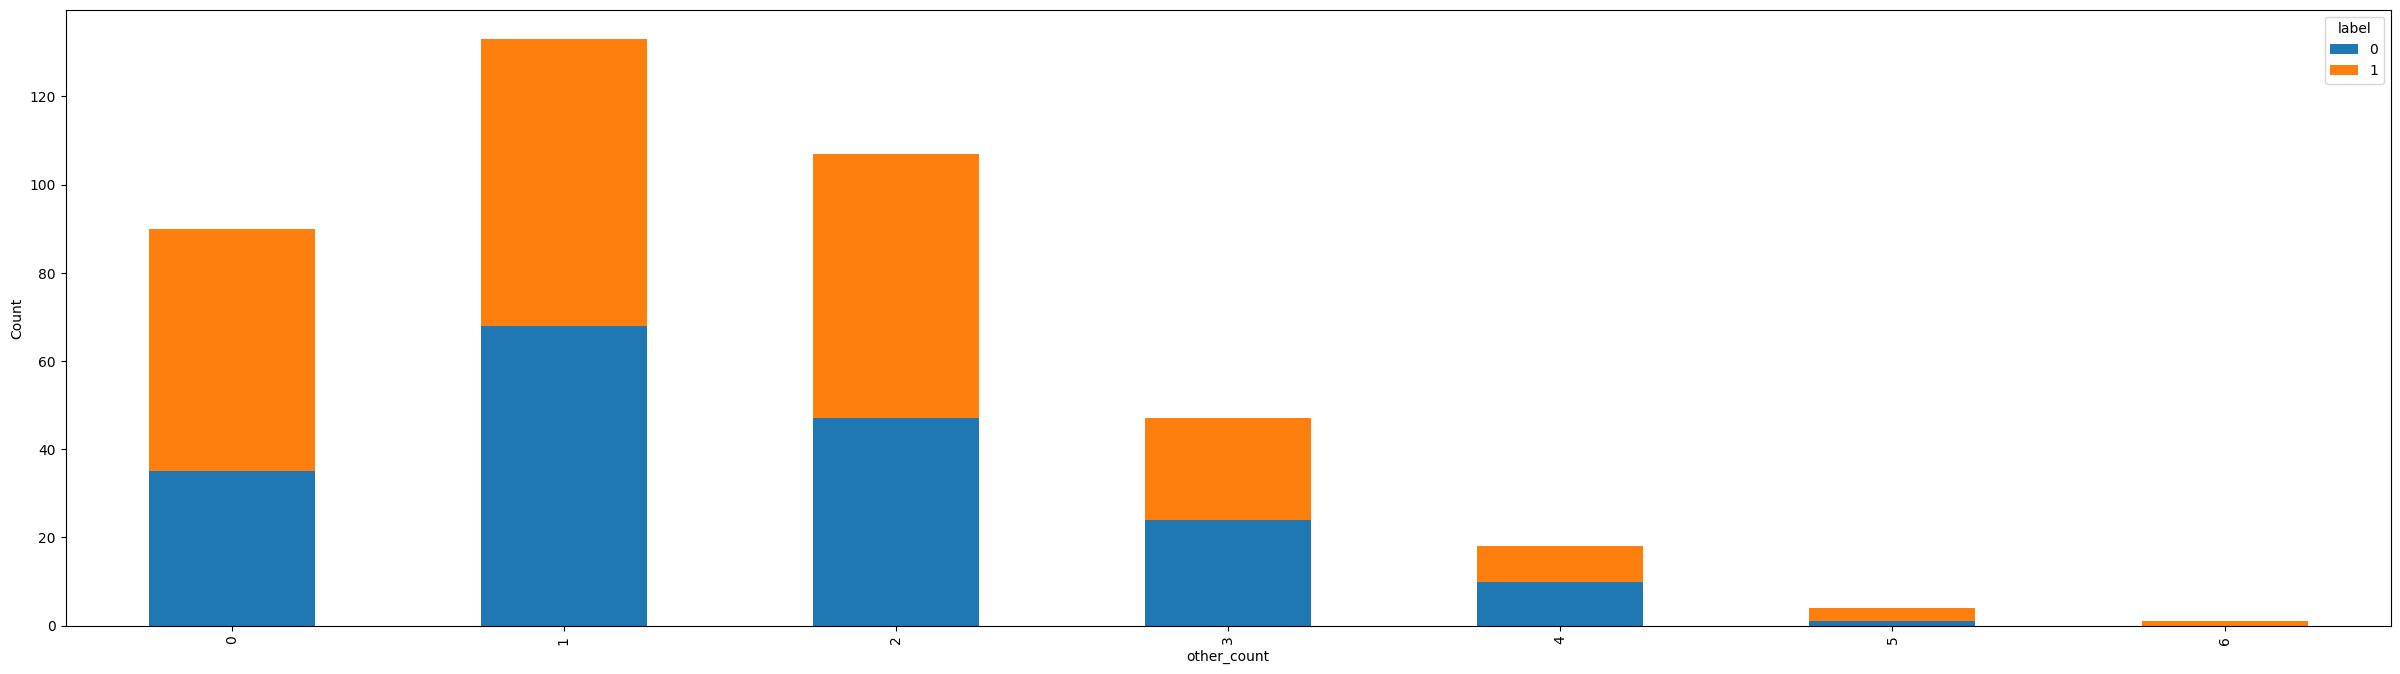

In [14]:
# We have 2 attributes that have normal distribution which are ms_count and orther_count so we use stacked bar chart to find relationship between attributes and label.
df = df_con[['mr_count','ms_count','other_count']]
for c in df.columns[1:]:
  PlotCatStackBar(c,"label",df_con)

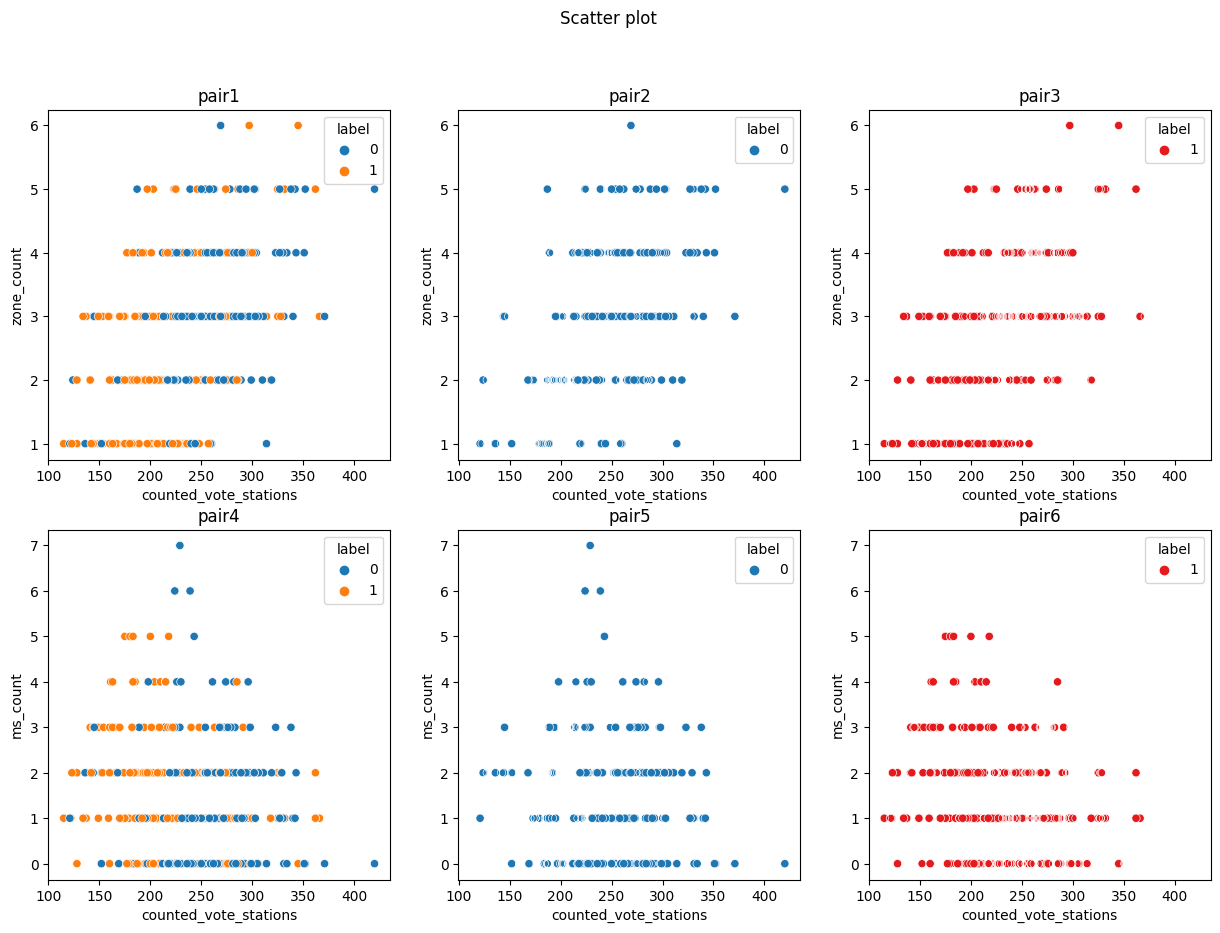

In [15]:
# scatterplot 3 usuable attributes which are counted_vote_stations(sure),zone_count and ms_count(doubt)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Scatter plot ')
sb.scatterplot(x='counted_vote_stations',y='zone_count',hue='label',data= df_con,ax=axes[0][0])
axes[0][0].set_title('pair1')
sb.scatterplot(x='counted_vote_stations',y='zone_count',hue='label',data=df_con,ax=axes[0][1],hue_order=[0])
axes[0][1].set_title('pair2')
sb.scatterplot(x='counted_vote_stations',y='zone_count',hue='label',data= df_con,ax=axes[0][2],hue_order=[1],palette='Set1')
axes[0][2].set_title('pair3')
sb.scatterplot(x='counted_vote_stations',y='ms_count',hue='label',data=df_con,ax=axes[1][0])
axes[1][0].set_title('pair4')
sb.scatterplot(x='counted_vote_stations',y='ms_count',hue='label',data=df_con,ax=axes[1][1],hue_order=[0])
axes[1][1].set_title('pair5')
sb.scatterplot(x='counted_vote_stations',y='ms_count',hue='label',data=df_con,ax=axes[1][2],hue_order=[1],palette='Set1')
axes[1][2].set_title('pair6')
plt.show()

analysis : from visualize above we found that there is  only counted_vote_stations that have an acceptable anova score and seperable median in boxplot.

# Model training

In [16]:
# Normalize data using minmax scaler
scaler_minmax = MinMaxScaler()
norm_attribute = df_con[['registered_vote',	'counted_vote_stations',	'zone_count',	'mr_count',	'ms_count',	'other_count']]
norm_attribute = scaler_minmax.fit_transform(norm_attribute)
norm_attribute = pd.DataFrame(norm_attribute)
norm_attribute.columns = ['registered_vote',	'counted_vote_stations',	'zone_count',	'mr_count',	'ms_count',	'other_count']
label = df_con['label']
norm_attribute.head()


,registered_vote,counted_vote_stations,zone_count,mr_count,ms_count,other_count
0,0.661912,0.639344,0.2,0.466667,0.285714,0.333333
1,0.781704,0.708197,0.8,0.400000,0.142857,0.500000
2,0.280526,0.406557,0.4,0.266667,0.000000,0.333333
3,0.289884,0.452459,0.8,0.266667,0.428571,0.000000
4,0.585063,0.363934,0.2,0.400000,0.142857,0.166667


In [17]:
randomState = 11
#train model using one attribute( coutned_vote station)
data_x = norm_attribute['counted_vote_stations']
data_y = label
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size = 0.2,random_state = randomState)
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)
from sklearn.tree import DecisionTreeClassifier
model_DecisionTree = DecisionTreeClassifier(criterion='entropy',)
model_DecisionTree.fit(X_train, y_train)
print('Accuracy of trainning set:{:.2f}'.format(model_DecisionTree.score(X_train, y_train)))
print('Accuracy of testing set:{:.2f}'.format(model_DecisionTree.score(X_test, y_test)))

Accuracy of trainning set:0.81
Accuracy of testing set:0.61


In [18]:
#Considering which attribute can used with counted_vote_stations to gain accuracy
print('/////////////////////////////////////////   counted_vote_stations and zone_count    ///////////////////////////////////////////////')
data_x = norm_attribute[['counted_vote_stations','zone_count']]
data_y = label
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size = 0.2,random_state = randomState)
from sklearn.tree import DecisionTreeClassifier
model_DecisionTree = DecisionTreeClassifier(criterion='entropy')
model_DecisionTree.fit(X_train, y_train)
print('Accuracy of trainning set:{:.2f}'.format(model_DecisionTree.score(X_train, y_train)))
print('Accuracy of testing set:{:.2f}'.format(model_DecisionTree.score(X_test, y_test)))

print('/////////////////////////////////////////   counted_vote_stations and ms_count    ///////////////////////////////////////////////')

data_x = norm_attribute[['counted_vote_stations','ms_count']]
data_y = label
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size = 0.2,random_state = randomState) 
from sklearn.tree import DecisionTreeClassifier
model_DecisionTree = DecisionTreeClassifier(criterion='entropy')
model_DecisionTree.fit(X_train, y_train)
print('Accuracy of trainning set:{:.2f}'.format(model_DecisionTree.score(X_train, y_train)))
print('Accuracy of testing set:{:.2f}'.format(model_DecisionTree.score(X_test, y_test)))

print('/////////////////////////////////////////   counted_vote_stations and ms_count and zone_count    ///////////////////////////////////////////////')

data_x = norm_attribute[['counted_vote_stations','ms_count','zone_count']]
data_y = label
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size = 0.2,random_state = randomState)
from sklearn.tree import DecisionTreeClassifier
model_DecisionTree = DecisionTreeClassifier(criterion='entropy')
model_DecisionTree.fit(X_train, y_train)
print('Accuracy of trainning set:{:.2f}'.format(model_DecisionTree.score(X_train, y_train)))
print('Accuracy of testing set:{:.2f}'.format(model_DecisionTree.score(X_test, y_test)))


/////////////////////////////////////////   counted_vote_stations and zone_count    ///////////////////////////////////////////////
Accuracy of trainning set:0.91
Accuracy of testing set:0.64
/////////////////////////////////////////   counted_vote_stations and ms_count    ///////////////////////////////////////////////
Accuracy of trainning set:0.92
Accuracy of testing set:0.62
/////////////////////////////////////////   counted_vote_stations and ms_count and zone_count    ///////////////////////////////////////////////
Accuracy of trainning set:0.97
Accuracy of testing set:0.59


## analysis
Using counted_vote_stations and zone_count give the best performance.

Next goal : Considering is depth hyperparameter of decistion tree model affect to over-fit.

In [19]:
#experiment
max_depth = 10
for i in range(max_depth):
    data_x = norm_attribute[['counted_vote_stations','zone_count']]
    data_y = label
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size = 0.2,random_state = 2) 
    from sklearn.tree import DecisionTreeClassifier
    model_DecisionTree = DecisionTreeClassifier(criterion='entropy',max_depth=i+1)
    model_DecisionTree.fit(X_train, y_train)
    print(f'////////////////////////////////////   {(i+1)}  ///////////////////////////////////////')
    print('Accuracy of trainning set:{:.2f}'.format(model_DecisionTree.score(X_train, y_train)))
    print('Accuracy of testing set:{:.2f}'.format(model_DecisionTree.score(X_test, y_test)))

////////////////////////////////////   1  ///////////////////////////////////////
Accuracy of trainning set:0.67
Accuracy of testing set:0.66
////////////////////////////////////   2  ///////////////////////////////////////
Accuracy of trainning set:0.68
Accuracy of testing set:0.69
////////////////////////////////////   3  ///////////////////////////////////////
Accuracy of trainning set:0.70
Accuracy of testing set:0.74
////////////////////////////////////   4  ///////////////////////////////////////
Accuracy of trainning set:0.72
Accuracy of testing set:0.66
////////////////////////////////////   5  ///////////////////////////////////////
Accuracy of trainning set:0.75
Accuracy of testing set:0.70
////////////////////////////////////   6  ///////////////////////////////////////
Accuracy of trainning set:0.77
Accuracy of testing set:0.66
////////////////////////////////////   7  ///////////////////////////////////////
Accuracy of trainning set:0.79
Accuracy of testing set:0.68
//////

The best max depth is 3 giving accuracy of trainning set: 0.70 and accuracy of testing set: 0.74.

In [20]:
#perform max depth = 3
data_x = norm_attribute[['counted_vote_stations','zone_count']]
data_y = label
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size = 0.2,random_state = 2) 
# X_train = np.array(X_train).reshape(-1, 1)
# X_test = np.array(X_test).reshape(-1, 1)
from sklearn.tree import DecisionTreeClassifier
best_model_DecisionTree = DecisionTreeClassifier(criterion='entropy',max_depth=3)
best_model_DecisionTree.fit(X_train, y_train)
print('Accuracy of trainning set:{:.2f}'.format(best_model_DecisionTree.score(X_train, y_train)))
print('Accuracy of testing set:{:.2f}'.format(best_model_DecisionTree.score(X_test, y_test)))

Accuracy of trainning set:0.70
Accuracy of testing set:0.74


In [21]:
#Predict on test set
y_pred = best_model_DecisionTree.predict(X_test)

# Classification report
from sklearn.metrics import classification_report,confusion_matrix
print("Classification report \n=======================")
print(classification_report(y_true=y_test, y_pred=y_pred))
print("Confusion matrix \n=======================")
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.63      0.88      0.73        33
           1       0.88      0.64      0.74        47

    accuracy                           0.74        80
   macro avg       0.76      0.76      0.74        80
weighted avg       0.78      0.74      0.74        80

Confusion matrix 
[[29  4]
 [17 30]]


<Figure size 640x480 with 0 Axes>

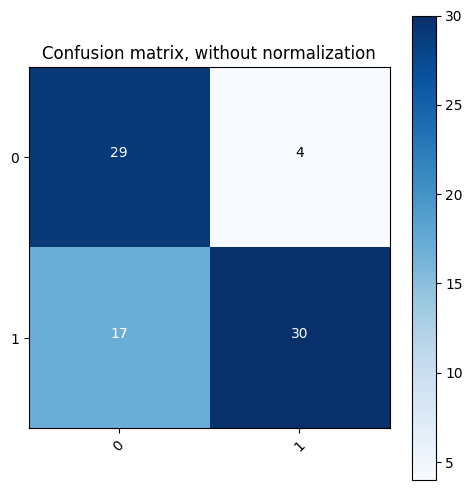

In [22]:
# Compute confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):

  plt.figure(figsize=(5,5))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()


class_names = list(set(y_train))
cnf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_21632\87578454.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


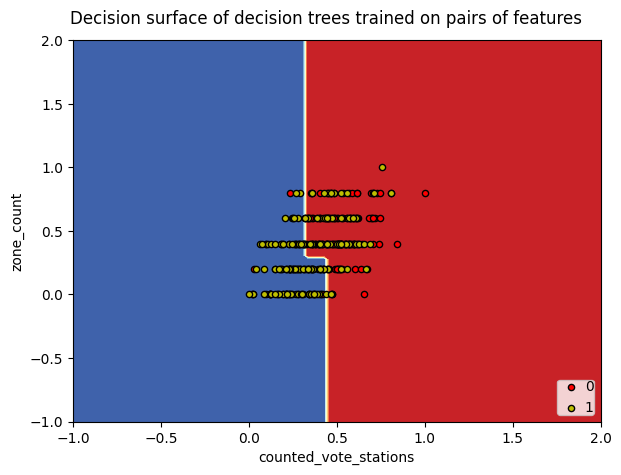

In [23]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 2
plot_colors = "ryb"
plot_step = 0.02
label=[0,1]



X = np.array(X_train)
y = np.array(y_train)

# Train
clf = best_model_DecisionTree
ax = plt.subplot(1,1,1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel='counted_vote_stations',
        ylabel='zone_count',
    )

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=label[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=20,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")